In [1]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

/home/dhiraj/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dhiraj/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [4]:
# Load an image
img_path = '../dataset/screw_and_bolt/bolts/images.jpeg'
img = Image.open(img_path).convert("RGB")

In [5]:
# Preprocess the image
transform = T.Compose([T.ToTensor()])
img = transform(img)

In [6]:
# Add a batch dimension
img = img.unsqueeze(0)

In [7]:
# Perform inference
with torch.no_grad():
    prediction = model(img)

In [8]:
# Visualize the results
def plot_image(image, masks, boxes):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    for i in range(len(masks)):
        mask = masks[i].cpu().numpy().squeeze()  # Squeeze the mask to remove extra dimensions
        box = boxes[i].cpu().numpy()
        ax.imshow(mask, alpha=0.5)
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red')
        ax.add_patch(rect)
    plt.show()

In [9]:
# Convert image back to numpy
img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()

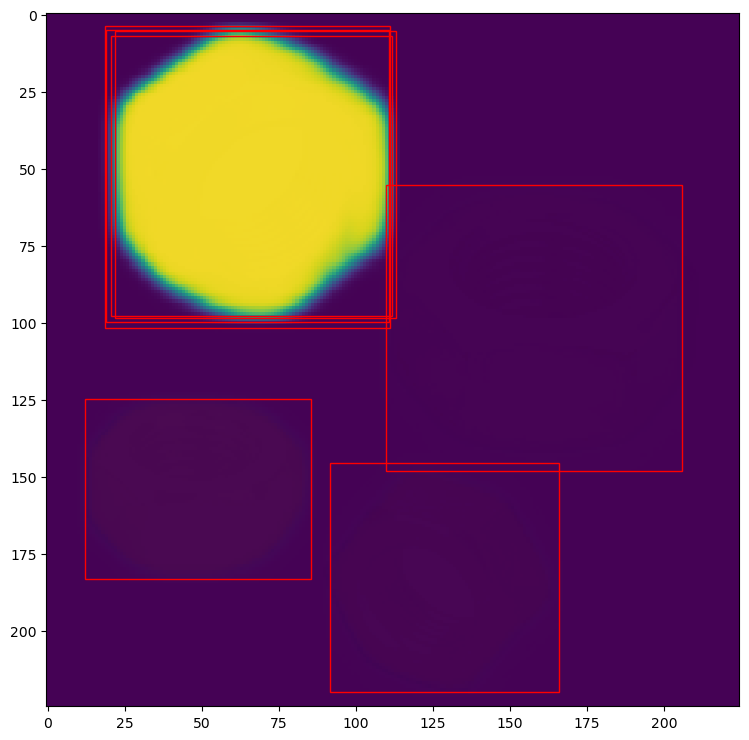

In [10]:
# Plot the image with masks and bounding boxes
plot_image(img_np, prediction[0]['masks'], prediction[0]['boxes'])

In [11]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [12]:
# Function to predict masks using the pre-trained model
def predict_masks(image_path):
    image = Image.open(image_path).convert("RGB")
    image = F.to_tensor(image).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(image)
    return prediction

In [13]:
# Function to visualize and save masks
def save_prediction(image_path, prediction, output_dir):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    masks = prediction[0]['masks'].cpu().numpy()
    for mask in masks:
        plt.imshow(mask[0], alpha=0.5, cmap='jet')
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    plt.savefig(output_path)
    plt.close()

In [14]:
# Predict and save masks for all images in the dataset
def generate_masks(dataset_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    total_images = sum([len(files) for r, d, files in os.walk(dataset_dir)])
    current_image = 0
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                current_image += 1
                print(f'Processing {current_image}/{total_images}: {file}')
                image_path = os.path.join(root, file)
                try:
                    prediction = predict_masks(image_path)
                    save_prediction(image_path, prediction, output_dir)
                except Exception as e:
                    print(f'Error processing {file}: {e}')

In [15]:
# Define the dataset directory and output directory for masks
dataset_dir = '../dataset/screw_and_bolt/'
output_dir = '../dataset/screw_and_bolt/masks'

In [ ]:
# Generate and save masks for the dataset
generate_masks(dataset_dir, output_dir)

In [2]:
# this class is to creat the dataset 
class ScrewBoltDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(image_dir)))

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.imgs[idx])
        mask_path = os.path.join(self.mask_dir, self.imgs[idx].replace('.jpg', '.png'))

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        img = F.to_tensor(img)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # remove background

        masks = mask == obj_ids[:, None, None]
        boxes = []
        for i in range(len(obj_ids)):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

NameError: name 'Dataset' is not defined

In [ ]:
dataset = ScrewBoltDataset(image_dir, mask_dir, transforms=None)

In [ ]:
# Create DataLoader
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Load the Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Modify the model's head for the custom dataset
num_classes = 3  # background + screw + bolt
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Define the device and move the model to it
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader, device=device)

In [ ]:
def get_predictions(image_path):
    image = Image.open(image_path).convert("RGB")
    image = F.to_tensor(image).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = model(image)
    return predictions


In [ ]:
def count_objects(predictions, label):
    pred_labels = predictions[0]['labels'].cpu().numpy()
    pred_masks = predictions[0]['masks'].cpu().numpy()
    count = np.sum(pred_labels == label)
    return count, pred_masks[pred_labels == label]

In [ ]:
# Define labels for screws and bolts
SCREW_LABEL = 1
BOLT_LABEL = 2

In [ ]:
# Function to visualize and count objects
def visualize_and_count(image_path):
    predictions = get_predictions(image_path)
    screw_count, screw_masks = count_objects(predictions, SCREW_LABEL)
    bolt_count, bolt_masks = count_objects(predictions, BOLT_LABEL)

    # Visualize the results
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    for mask in screw_masks:
        plt.imshow(mask[0], alpha=0.5, cmap='Blues')
    for mask in bolt_masks:
        plt.imshow(mask[0], alpha=0.5, cmap='Reds')

    plt.title(f'Screws: {screw_count}, Bolts: {bolt_count}')
    plt.show()

    return screw_count, bolt_count

In [ ]:
# Example usage
image_path = '../dataset/screw_and_bolt/screw/20240713_192951.jpg'
screw_count, bolt_count = visualize_and_count(image_path)
print(f'Screw count: {screw_count}, Bolt count: {bolt_count}')